In [1]:
import pandas as pd
from pymongo import MongoClient
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from decimal import Decimal
import odds_data_getter as odg


In [2]:
teams_df = pd.read_json('/Users/ccuulinay/github_proj/scrapy_proj/nba_odds_spider/lab/collection_backup/all_teams.json')

In [3]:
teams_df.drop(['TEAM_CITY', 'TEAM_NAME'],axis=1, inplace=True)

In [4]:
advanced_stat_df = pd.read_json('./advanced_data_slice_201702.json')

In [5]:
def read_n_preprocess_ah_df():
    ah_df = odg.read_mongo_data_to_dataframe()
    ah_df = ah_df[ah_df.away_team != 'Team USA']
    ah_df = ah_df[ah_df.away_team != 'West']
    ah_df = ah_df[ah_df.home_team != 'Team World']
    ah_df = ah_df[ah_df.away_team != 'EAST']
    
    ah_df = ah_df.merge(teams_df, how='left', left_on='away_team', right_on='FULL_TEAM_NAME')
    ah_df.drop(['FULL_TEAM_NAME'],axis=1, inplace=True)
    ah_df.rename(columns={'TEAM_ID': 'away_team_id'}, inplace=True)
    ah_df = ah_df.merge(teams_df, how='left', left_on='home_team', right_on='FULL_TEAM_NAME')
    ah_df.drop(['FULL_TEAM_NAME'],axis=1, inplace=True)
    ah_df.rename(columns={'TEAM_ID': 'home_team_id'}, inplace=True)
    
    ah_df['winner'] = np.where(ah_df['score_home'] - ah_df['score_away'] > 0, 'home', 'away')
    ah_df['ot'] = ah_df['overtime'].apply(lambda x: 1 if x == True else 0)
    ah_df['home_win'] = ah_df['winner'].apply(lambda x: 1 if x == 'home' else 0)

    ah_df['date_time_DT'] = pd.to_datetime(ah_df['date_time'])
    ah_df['year'] = ah_df['date_time_DT'].dt.year.astype(int)
    ah_df['month'] = ah_df['date_time_DT'].dt.month.astype(int)
    ah_df['day'] = ah_df['date_time_DT'].dt.day.astype(int)
    ah_df['weekDay'] = ah_df['date_time_DT'].dt.dayofweek.astype(int)

    for i in range(1, 5):
        ah_df["new_odd_home_" + str(i)] = ah_df["odd_home_" + str(i)].apply(lambda x: odg.to_decimal(x))
        ah_df["new_odd_away_" + str(i)] = ah_df["odd_away_" + str(i)].apply(lambda x: odg.to_decimal(x))
        ah_df["new_odd_home_" + str(i)] = ah_df["new_odd_home_" + str(i)].astype(float)
        ah_df["new_odd_away_" + str(i)] = ah_df["new_odd_away_" + str(i)].astype(float)

    ah_df.drop(
        ['odd_home_1', 'odd_home_2', 'odd_home_3', 'odd_home_4', 'odd_away_1', 'odd_away_2', 'odd_away_3',
         'odd_away_4'],
        axis=1, inplace=True)
    
    one_hot = pd.get_dummies(ah_df[['away_team', 'home_team']], prefix=['away_team_', 'home_team_'])
    ah_df = ah_df.join(one_hot)
    ah_df.drop(['away_team', 'home_team'], axis=1, inplace=True)
    ah_df.drop(['date_time', 'date_time_DT', 'winner', 'overtime'], axis=1, inplace=True)

    ah_df['total_score'] = ah_df['score_home'] + ah_df['score_away']
    ah_df['sub_score'] = ah_df['score_home'] - ah_df['score_away']
    
    # ah_df['bet_winner'] = np.where(float(row['sub_score']) + float(row['ah_'+str(num)]) >= 0, 'home', 'away')

    ah_df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
    return ah_df

In [6]:
ah_df = read_n_preprocess_ah_df()

In [7]:
COLUMNS = ['away_team__Atlanta_Hawks',
           'away_team__Boston_Celtics',
           'away_team__Brooklyn_Nets',
           'away_team__Charlotte_Hornets',
           'away_team__Chicago_Bulls',
           'away_team__Cleveland_Cavaliers',
           'away_team__Dallas_Mavericks',
           'away_team__Denver_Nuggets',
           'away_team__Detroit_Pistons',
           'away_team__Golden_State_Warriors',
           'away_team__Houston_Rockets',
           'away_team__Indiana_Pacers',
           'away_team__Los_Angeles_Clippers',
           'away_team__Los_Angeles_Lakers',
           'away_team__Memphis_Grizzlies',
           'away_team__Miami_Heat',
           'away_team__Milwaukee_Bucks',
           'away_team__Minnesota_Timberwolves',
           'away_team__New_Orleans_Pelicans',
           'away_team__New_York_Knicks',
           'away_team__Oklahoma_City_Thunder',
           'away_team__Orlando_Magic',
           'away_team__Philadelphia_76ers',
           'away_team__Phoenix_Suns',
           'away_team__Portland_Trail_Blazers',
           'away_team__Sacramento_Kings',
           'away_team__San_Antonio_Spurs',
           'away_team__Toronto_Raptors',
           'away_team__Utah_Jazz',
           'away_team__Washington_Wizards',
           'home_team__Atlanta_Hawks',
           'home_team__Boston_Celtics',
           'home_team__Brooklyn_Nets',
           'home_team__Charlotte_Hornets',
           'home_team__Chicago_Bulls',
           'home_team__Cleveland_Cavaliers',
           'home_team__Dallas_Mavericks',
           'home_team__Denver_Nuggets',
           'home_team__Detroit_Pistons',
           'home_team__Golden_State_Warriors',
           'home_team__Houston_Rockets',
           'home_team__Indiana_Pacers',
           'home_team__Los_Angeles_Clippers',
           'home_team__Los_Angeles_Lakers',
           'home_team__Memphis_Grizzlies',
           'home_team__Miami_Heat',
           'home_team__Milwaukee_Bucks',
           'home_team__Minnesota_Timberwolves',
           'home_team__New_Orleans_Pelicans',
           'home_team__New_York_Knicks',
           'home_team__Oklahoma_City_Thunder',
           'home_team__Orlando_Magic',
           'home_team__Philadelphia_76ers',
           'home_team__Phoenix_Suns',
           'home_team__Portland_Trail_Blazers',
           'home_team__Sacramento_Kings',
           'home_team__San_Antonio_Spurs',
           'home_team__Toronto_Raptors',
           'home_team__Utah_Jazz',
           'home_team__Washington_Wizards',
           'away_team_id',
           'home_team_id',
           'ah_1',
#            'odd_cnt_1',
           'new_odd_home_1',
           'new_odd_away_1',
#            'ah_2',
#            'odd_cnt_2',
#            'new_odd_home_2',
#            'new_odd_away_2',
#            'ah_3',
#            'odd_cnt_3',
#            'new_odd_home_3',
#            'new_odd_away_3',
#            'ah_4',
#            'odd_cnt_4',
#            'new_odd_home_4',
#            'new_odd_away_4',
           'year',
           'month',
           'day',
           'weekDay',
#            'ot',
           'home_win',
           'score_away',
           'score_home',
           'total_score',
           'sub_score']

FEATURES = COLUMNS[:-5]

In [8]:
ah_df = ah_df[COLUMNS]
home_win = ah_df['home_win']
sub_score = ah_df['sub_score']
ah_df.sort_values(by=['year', 'month','day'], ascending=[1, 1, 1], inplace=True)

In [9]:
ah_df.head()

,away_team__Atlanta_Hawks,away_team__Boston_Celtics,away_team__Brooklyn_Nets,away_team__Charlotte_Hornets,away_team__Chicago_Bulls,away_team__Cleveland_Cavaliers,away_team__Dallas_Mavericks,away_team__Denver_Nuggets,away_team__Detroit_Pistons,away_team__Golden_State_Warriors,...,new_odd_away_1,year,month,day,weekDay,home_win,score_away,score_home,total_score,sub_score
1185,0,0,0,0,0,0,0,0,0,0,...,1.89,2014,10,5,6,0,98,86,184,-12
1186,0,0,0,0,0,0,0,0,0,0,...,1.92,2014,10,6,0,1,94,99,193,5
1187,0,0,0,0,0,0,0,0,0,0,...,1.91,2014,10,7,1,1,78,98,176,20
1188,0,0,0,0,0,0,0,0,0,0,...,1.89,2014,10,7,1,1,87,93,180,6
1190,0,0,0,0,0,0,0,1,0,0,...,1.90,2014,10,7,1,1,95,98,193,3


In [10]:
result_df = pd.merge(advanced_stat_df, ah_df, left_index=True, right_index=True, how='inner')

In [16]:
NEW_COLUMNS = result_df.columns.tolist()
NEW_FEATURES = NEW_COLUMNS[:-5]

In [17]:
result_data = result_df.as_matrix()
result_data.shape

(3591, 152)

In [18]:
train_data = result_data[:,:-5]
train_label = result_data[:,-5:].astype(int)

In [19]:
from sklearn.ensemble import RandomForestRegressor
x_train, x_test, y_train, y_test = train_test_split(train_data,train_label[:,4], test_size=0.3)
clf = RandomForestRegressor(n_estimators=200, criterion='mse', max_depth=4)

# clf = Pipeline([
#         ('ss', StandardScaler()),
#         ('DTC', RandomForestRegressor(n_estimators=230, criterion='mse', max_depth=4))])
rf_clf = clf.fit(x_train, y_train)
y_hat = rf_clf.predict(x_test)

In [20]:
payout_df = pd.DataFrame(x_test, columns=NEW_FEATURES)
payout_df['predict_subscore'] = y_hat
payout_df['home_win'] = home_win
payout_df['sub_score'] = sub_score
# payout_df.head()
payout_df['payout_1'] = payout_df.apply(lambda x : odg.calculate_payout(x), axis=1)
# payout_df['payout_2'] = payout_df.apply(lambda x : calculate_payout(x, num=2), axis=1)
# payout_df['payout_3'] = payout_df.apply(lambda x : calculate_payout(x, num=3), axis=1)
# payout_df['payout_4'] = payout_df.apply(lambda x : calculate_payout(x, num=4), axis=1)
payout_df.payout_1.sum() # ,payout_df.payout_2.sum(),payout_df.payout_3.sum(),payout_df.payout_4.sum()

78.580158840314184

In [21]:
# Try XGBoost on subscore
import xgboost as xgb
x_train, x_test, y_train, y_test = train_test_split(train_data,train_label[:,4], test_size=0.3)

data_train = xgb.DMatrix(x_train, label=y_train)
data_test = xgb.DMatrix(x_test, label=y_test)
watch_list = [(data_test, 'eval'), (data_train, 'train')]
param = {'max_depth': 4, 'eta': 1, 'silent': 1, 'objective': 'reg:linear'}
bst = xgb.train(param, data_train, num_boost_round=6, evals=watch_list)
y_hat = bst.predict(data_test)

[0]	eval-rmse:12.4379	train-rmse:11.6169
[1]	eval-rmse:12.7128	train-rmse:11.3283
[2]	eval-rmse:12.7667	train-rmse:11.0821
[3]	eval-rmse:12.9821	train-rmse:10.823
[4]	eval-rmse:13.3156	train-rmse:10.5354
[5]	eval-rmse:13.4879	train-rmse:10.3295


/Users/ccuulinay/.pyenv/versions/2.7.9/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [22]:
payout_df = pd.DataFrame(x_test, columns=NEW_FEATURES)
payout_df['predict_subscore'] = y_hat
payout_df['home_win'] = home_win
payout_df['sub_score'] = sub_score
payout_df.head()
payout_df['payout_1'] = payout_df.apply(lambda x : odg.calculate_payout(x), axis=1)
#payout_df['payout_2'] = payout_df.apply(lambda x : calculate_payout(x, num=2), axis=1)
#payout_df['payout_3'] = payout_df.apply(lambda x : calculate_payout(x, num=3), axis=1)
#payout_df['payout_4'] = payout_df.apply(lambda x : calculate_payout(x, num=4), axis=1)
payout_df.payout_1.sum()#, payout_df.payout_2.sum(),payout_df.payout_3.sum(),payout_df.payout_4.sum()

-46.446910668939559

In [27]:
# Build a linear regressor for subscore
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV

x_train, x_test, y_train, y_test = train_test_split(train_data,train_label[:,4], test_size=0.3)

linreg = LinearRegression()
Lasreg = Lasso()
Ridreg = Ridge()
# lr_model = linreg.fit(x_train, y_train)
lr_model = Lasreg.fit(x_train, y_train)
# lr_model = Ridreg.fit(x_train, y_train)
# y_hat = linreg.predict(x_test)
y_hat = Lasreg.predict(x_test)
# y_hat = Ridreg.predict(x_test)

In [28]:
payout_df = pd.DataFrame(x_test, columns=NEW_FEATURES)
payout_df['predict_subscore'] = y_hat
payout_df['home_win'] = home_win
payout_df['sub_score'] = sub_score
payout_df.head()
payout_df['payout_1'] = payout_df.apply(lambda x : odg.calculate_payout(x), axis=1)
# payout_df['payout_2'] = payout_df.apply(lambda x : calculate_payout(x, num=2), axis=1)
# payout_df['payout_3'] = payout_df.apply(lambda x : calculate_payout(x, num=3), axis=1)
# payout_df['payout_4'] = payout_df.apply(lambda x : calculate_payout(x, num=4), axis=1)
payout_df.payout_1.sum()# , payout_df.payout_2.sum(),payout_df.payout_3.sum(),payout_df.payout_4.sum()

226.6739995066111

In [29]:
team_list = ['Atlanta_Hawks',
'Boston_Celtics',
'Brooklyn_Nets',
'Charlotte_Hornets',
'Chicago_Bulls',
'Cleveland_Cavaliers',
'Dallas_Mavericks',
'Denver_Nuggets',
'Detroit_Pistons',
'Golden_State_Warriors',
'Houston_Rockets',
'Indiana_Pacers',
'Los_Angeles_Clippers',
'Los_Angeles_Lakers',
'Memphis_Grizzlies',
'Miami_Heat',
'Milwaukee_Bucks',
'Minnesota_Timberwolves',
'New_Orleans_Pelicans',
'New_York_Knicks',
'Oklahoma_City_Thunder',
'Orlando_Magic',
'Philadelphia_76ers',
'Phoenix_Suns',
'Portland_Trail_Blazers',
'Sacramento_Kings',
'San_Antonio_Spurs',
'Toronto_Raptors',
'Utah_Jazz',
'Washington_Wizards']

In [30]:
away_payout = []
home_payout = []
for i in team_list:
    away_payout.append([i,payout_df[payout_df['away_team__'+i] == 1].payout_1.sum()])
    home_payout.append([i,payout_df[payout_df['home_team__'+i] == 1].payout_1.sum()])
# away_payout = np.array(away_payout)
# home_payout = np.array(home_payout)

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
sorted(away_payout, key=lambda x:x[1], reverse=True)

[['Golden_State_Warriors', 18.759823840099344],
 ['Los_Angeles_Clippers', 18.75],
 ['Oklahoma_City_Thunder', 17.876703296605552],
 ['Cleveland_Cavaliers', 17.586318082788669],
 ['Boston_Celtics', 13.337421823459557],
 ['Los_Angeles_Lakers', 12.986978641587593],
 ['Phoenix_Suns', 11.95585734879508],
 ['Denver_Nuggets', 10.460900900900899],
 ['Houston_Rockets', 10.147958658721997],
 ['Chicago_Bulls', 9.3233571185864754],
 ['Washington_Wizards', 8.9249932191291137],
 ['Orlando_Magic', 8.3772189836895716],
 ['Dallas_Mavericks', 7.9621417179311909],
 ['Minnesota_Timberwolves', 7.450589208871234],
 ['Milwaukee_Bucks', 7.3745794392523365],
 ['Indiana_Pacers', 6.5859259259259257],
 ['Philadelphia_76ers', 6.5379756656674299],
 ['New_York_Knicks', 5.9687830687830683],
 ['Atlanta_Hawks', 5.5299999999999994],
 ['Memphis_Grizzlies', 5.4599999999999982],
 ['Sacramento_Kings', 5.3154068583279814],
 ['Charlotte_Hornets', 4.6223809523809507],
 ['Brooklyn_Nets', 4.4349557522123879],
 ['Utah_Jazz', 4.179

In [33]:
sorted(home_payout, key=lambda x:x[1], reverse=True)

[['Cleveland_Cavaliers', 18.883396226415091],
 ['Golden_State_Warriors', 18.7196787703894],
 ['San_Antonio_Spurs', 16.869090909090911],
 ['Detroit_Pistons', 16.7628923100512],
 ['Toronto_Raptors', 15.917933757279551],
 ['New_Orleans_Pelicans', 12.839170209106264],
 ['Philadelphia_76ers', 10.350981365733979],
 ['Los_Angeles_Lakers', 10.170303311805236],
 ['Memphis_Grizzlies', 10.059090909090909],
 ['Chicago_Bulls', 9.849252879528386],
 ['Indiana_Pacers', 9.0080970811159489],
 ['Boston_Celtics', 8.7387830687830661],
 ['Brooklyn_Nets', 8.2494762327019782],
 ['Denver_Nuggets', 8.1581818181818182],
 ['Milwaukee_Bucks', 7.6093221523410204],
 ['Dallas_Mavericks', 6.7045794392523357],
 ['Houston_Rockets', 6.4399999999999986],
 ['Minnesota_Timberwolves', 6.1954260841037163],
 ['Orlando_Magic', 5.2271929824561401],
 ['Atlanta_Hawks', 4.5888103442465784],
 ['Phoenix_Suns', 4.5095739348370909],
 ['Charlotte_Hornets', 4.457457627118643],
 ['Oklahoma_City_Thunder', 3.7279756656674294],
 ['Los_Angele

# Plot the payout from each team of home and road game
Model perform the best on 76ers. Most like because 76ers has been so bad during last three years and easy to predict (It will lost the game and the bet!!!). And seem my model play better on road game than home game.

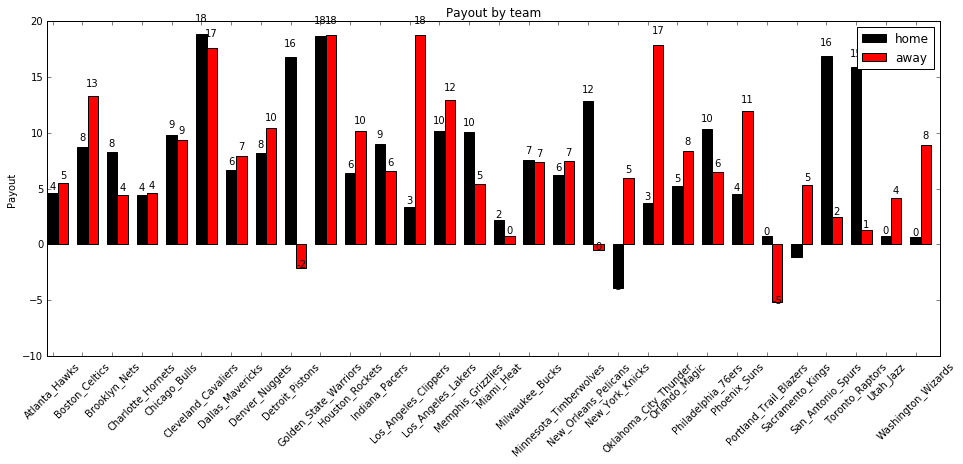

In [34]:
fig = plt.figure(figsize=(16,6),dpi=80)
ax = fig.add_subplot(111)
N = 30

ind = np.arange(N)
width = 0.35

rects1 = ax.bar(ind, np.array(home_payout)[:,1], width,
                color='black')

rects2 = ax.bar(ind+width, np.array(away_payout)[:,1], width,
                color='red')

ax.set_ylabel('Payout')
ax.set_title('Payout by team')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((x for x in np.array(home_payout)[:,0]), rotation=45)


ax.legend((rects1[0], rects2[0]), ('home', 'away'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

In [42]:
def preprocess_today_df(teams_df, today_df):
    ah_df = today_df
    # ah_df = odg.read_mongo_data_to_dataframe()
    ah_df = ah_df[ah_df.away_team != 'Team USA']
    ah_df = ah_df[ah_df.away_team != 'West']
    ah_df = ah_df[ah_df.home_team != 'Team World']
    ah_df = ah_df[ah_df.away_team != 'EAST']
    
    ah_df = ah_df.merge(teams_df, how='left', left_on='away_team', right_on='FULL_TEAM_NAME')
    ah_df.drop(['FULL_TEAM_NAME'],axis=1, inplace=True)
    ah_df.rename(columns={'TEAM_ID': 'away_team_id'}, inplace=True)
    ah_df = ah_df.merge(teams_df, how='left', left_on='home_team', right_on='FULL_TEAM_NAME')
    ah_df.drop(['FULL_TEAM_NAME'],axis=1, inplace=True)
    ah_df.rename(columns={'TEAM_ID': 'home_team_id'}, inplace=True)
    
    ah_df['date_time_DT'] = pd.to_datetime(ah_df['date_time'])
    ah_df['year'] = ah_df['date_time_DT'].dt.year.astype(int)
    ah_df['month'] = ah_df['date_time_DT'].dt.month.astype(int)
    ah_df['day'] = ah_df['date_time_DT'].dt.day.astype(int)
    ah_df['weekDay'] = ah_df['date_time_DT'].dt.dayofweek.astype(int)
    
    ah_df["new_odd_home_1"] = ah_df["odd_home_1"].apply(lambda x: odg.to_decimal(str(x)))
    ah_df["new_odd_away_1"] = ah_df["odd_away_1"].apply(lambda x: odg.to_decimal(str(x)))
    ah_df["new_odd_home_1"] = ah_df["new_odd_home_1"].astype(float)
    ah_df["new_odd_away_1"] = ah_df["new_odd_away_1"].astype(float)
    ah_df.drop(['odd_home_1', 'odd_away_1'],axis=1, inplace=True)
    
#     for i in range(1, 5):
#         ah_df["new_odd_home_" + str(i)] = ah_df["odd_home_" + str(i)].apply(lambda x: odg.to_decimal(x))
#         ah_df["new_odd_away_" + str(i)] = ah_df["odd_away_" + str(i)].apply(lambda x: odg.to_decimal(x))
#         ah_df["new_odd_home_" + str(i)] = ah_df["new_odd_home_" + str(i)].astype(float)
#         ah_df["new_odd_away_" + str(i)] = ah_df["new_odd_away_" + str(i)].astype(float)

#     ah_df.drop(
#         ['odd_home_1', 'odd_home_2', 'odd_home_3', 'odd_home_4', 'odd_away_1', 'odd_away_2', 'odd_away_3',
#          'odd_away_4'],
#         axis=1, inplace=True)
    
    one_hot = pd.get_dummies(ah_df[['away_team', 'home_team']], prefix=['away_team_', 'home_team_'])
    ah_df = ah_df.join(one_hot)
    ah_df.drop(['away_team', 'home_team'], axis=1, inplace=True)
    ah_df.drop(['date_time', 'date_time_DT'], axis=1, inplace=True)
    # Create a empty base dataframe
    base_df = pd.DataFrame(columns=FEATURES)
    
    
    ah_df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
    ah_df = base_df.merge(ah_df, how='outer')
    ah_df = ah_df.fillna(value=0)
    ah_df = ah_df[FEATURES]
    
    temp_df = pd.DataFrame()
    temp_df = temp_df.append(ah_df.apply(lambda x: odg.get_advanced_data(x), axis=1))
    result_df = pd.merge(temp_df, ah_df, left_index=True, right_index=True, how='inner')
    
    return result_df

In [78]:
import pickle
pickle.dump(Lasreg, open("predict_score_Las.reg", "wb"))

In [84]:
def predict_tomorrow(input_df, teams_df):
    post_input_df = preprocess_today_df(teams_df, input_df)
    post_input_df = post_input_df[NEW_FEATURES]
    
    tt_data = post_input_df.as_matrix()
    tt_prediction = Lasreg.predict(tt_data)
    temp_df = input_df.copy()
    temp_df['predict_sub_score'] = tt_prediction
    return temp_df

In [102]:
input_20170313 = pd.read_json("/Users/ccuulinay/PycharmProjects/nba_data/nba_odds_ah_pregetter/6_item.json")
result_df = predict_tomorrow(input_20170313, teams_df)
result_df

,ah_1,away_team,date_time,home_team,odd_away_1,odd_cnt_1,odd_home_1,predict_sub_score
0,1.5,Orlando Magic,2017-03-14 04:30:00,Sacramento Kings,1.99,9,1.83,-0.807142
1,-7.0,Cleveland Cavaliers,2017-03-13 02:00:00,Houston Rockets,1.94,11,1.93,6.966425
2,-6.0,Atlanta Hawks,2017-03-14 02:00:00,San Antonio Spurs,1.87,3,1.97,6.762535
3,-2.0,Los Angeles Clippers,2017-03-14 04:00:00,Utah Jazz,1.95,3,1.95,2.115295
4,2.5,Portland Trail Blazers,2017-03-13 03:00:00,Phoenix Suns,19/20,12,9/10,-2.507238
5,-12.5,Los Angeles Lakers,2017-03-14 04:30:00,Denver Nuggets,1.87,7,1.94,12.621136
6,-4.5,Philadelphia 76ers,2017-03-13 03:30:00,Los Angeles Lakers,1.94,14,1.90,4.306476
7,-7.0,Chicago Bulls,2017-03-14 01:00:00,Charlotte Hornets,1.94,11,1.90,7.186526
8,-4.0,Dallas Mavericks,2017-03-14 01:30:00,Toronto Raptors,1.94,11,1.91,3.505783
9,-1.0,Washington Wizards,2017-03-14 02:00:00,Minnesota Timberwolves,1.93,11,1.91,0.737812


In [105]:
result_df[result_df.date_time >= "2017-03-14"]

,ah_1,away_team,date_time,home_team,odd_away_1,odd_cnt_1,odd_home_1,predict_sub_score
0,1.5,Orlando Magic,2017-03-14 04:30:00,Sacramento Kings,1.99,9,1.83,-0.807142
2,-6.0,Atlanta Hawks,2017-03-14 02:00:00,San Antonio Spurs,1.87,3,1.97,6.762535
3,-2.0,Los Angeles Clippers,2017-03-14 04:00:00,Utah Jazz,1.95,3,1.95,2.115295
5,-12.5,Los Angeles Lakers,2017-03-14 04:30:00,Denver Nuggets,1.87,7,1.94,12.621136
7,-7.0,Chicago Bulls,2017-03-14 01:00:00,Charlotte Hornets,1.94,11,1.90,7.186526
8,-4.0,Dallas Mavericks,2017-03-14 01:30:00,Toronto Raptors,1.94,11,1.91,3.505783
9,-1.0,Washington Wizards,2017-03-14 02:00:00,Minnesota Timberwolves,1.93,11,1.91,0.737812
10,-4.0,Milwaukee Bucks,2017-03-14 02:00:00,Memphis Grizzlies,1.91,11,1.93,4.514777


In [104]:
a = result_df[result_df.date_time >= "2017-03-14"].apply(lambda x : x.home_team if float(x.predict_sub_score) + float(x.ah_1) >0 else x.away_team ,axis=1)
a

0       Sacramento Kings
2      San Antonio Spurs
3              Utah Jazz
5         Denver Nuggets
7      Charlotte Hornets
8       Dallas Mavericks
9     Washington Wizards
10     Memphis Grizzlies
dtype: object